In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np 
import os, glob
import matplotlib
from astropy.io import ascii
from matplotlib import rc
from scipy import stats
from astropy.coordinates import SkyCoord
np.seterr(invalid='ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Set dir depending on machine 
directory = '/home/bethany/Projects/0_Data/0_SUMS_Catalogs/CandidateCatalog/'
# directory = '/Volumes/Untitled/0_Data/SUMS_Catalogs/Candidates/'

In [3]:
df = pd.read_csv(directory+'2_sed_reduced.csv')

# Drop anything that was cut from the sample
df = df[df.cut.isna()]

print('Initial Size: ', df.shape[0])

# Drop any unnamed columns
df = df.drop([col for col in df.columns if 'Unnamed' in col], axis=1)

# Reset the index
df = df.reset_index(drop=True)

# Replace the key 
df['key'] = np.arange(len(df))

# Replace number columns that have nans with 0
nan_cols = ['uvw2_num2p5', 'uvm2_num2p5', 'uvw1_num2p5','uvw2_num1', 'uvm2_num1', 'uvw1_num1']
[df.fillna({col:0}, inplace=True) for col in nan_cols]

# Add a column averaging how many neighbors are within 2.5"
df['max_2p5'] = df[['uvw2_num2p5', 'uvm2_num2p5', 'uvw1_num2p5']].max(axis=1)

# Add a column averaging how many neighbors are within 1"
df['max_1'] = df[['uvw2_num1', 'uvm2_num1', 'uvw1_num1']].max(axis=1)

# Add a column taking minimum of the closest star:
df['closest'] = df[['uvw2_closest_min', 'uvm2_closest_min', 'uvw1_closest_min']].min(axis=1)

#Add a column taking minimium and average of the UV flux fractions:
df['ff_min'] = df[['uvw2_flux_frac', 'uvm2_flux_frac', 'uvw1_flux_frac']].min(axis=1)
df['ff_avg'] = df[['uvw2_flux_frac', 'uvm2_flux_frac', 'uvw1_flux_frac']].mean(axis=1)

# Add a column for how many filters are present 
sed_columns = ['uvw2_dered','uvm2_dered','uvw1_dered','U_dered','B_dered','V_dered','I_dered']
df['n_filters'] = df[sed_columns].notna().sum(axis=1)

# Average distance from zams 
color_labels = ['uvw2 - b','uvw2 - v', 'uvw2 - i', 
                'uvw1 - b', 'uvw1 - v','uvw1 - i', 
                'uvm2 - b', 'uvm2 - v', 'uvm2 - i']
distance_labels = [f'{color} distance' for color in color_labels]
df['avg_zdis'] = df[distance_labels].mean(axis=1)

# Average distance weighted by errors (zsigma)
for col in color_labels:
    df[f'{col} zsigma'] = df[f'{col} distance'] / df[f'{col} err']
zsigma_labels = [f'{color} zsigma' for color in color_labels]
df['avg_zsigma'] = df[zsigma_labels].mean(axis=1)



Initial Size:  4649


In [ ]:
original_df = df.copy()

# Platinum 
platinum_index = df.loc[(df.n_filters == 7) & (df.avg_2p5 == 0 ) & (df.very_blue == 9 ) ,'key'].values

df.loc[df['key'].isin(platinum_index),'cut'] = 'platinum'
print(f'How many are platinum: ',len(df[df.cut == 'platinum']))  
print(f'In the SMC: ',len(df[(df.cut == 'platinum') & (df.galaxy == 'smc')]))
print(f'In the LMC: ',len(df[(df.cut == 'platinum') & (df.galaxy == 'lmc')]))  
print(f'How many remain: ',len(df[df.cut.isna()]))
print(' ')

# Diamond
diamond_index = df.loc[(df.cut.isna()) & (df.n_filters == 7) & (df.avg_2p5 == 0) & (df.very_blue >= 6) ,'key'].values                     

df.loc[df['key'].isin(diamond_index),'cut'] = 'diamond'
print(f'How many are diamond: ',len(df[df.cut == 'diamond']))  
print(f'In the SMC: ',len(df[(df.cut == 'diamond') & (df.galaxy == 'smc')]))
print(f'In the LMC: ',len(df[(df.cut == 'diamond') & (df.galaxy == 'lmc')]))  
print(f'How many remain: ',len(df[df.cut.isna()]))
print(' ')

# Gold 
gold_index = df.loc[(df.cut.isna()) & (df.n_filters > 5) & (df.avg_2p5 <= 1.) & (df.avg_1 == 0.) & (df.very_blue >= 5) ,'key'].values        

df.loc[df['key'].isin(gold_index),'cut'] = 'gold'
print(f'How many are gold: ',len(df[df.cut == 'gold']))  
print(f'In the SMC: ',len(df[(df.cut == 'gold') & (df.galaxy == 'smc')]))
print(f'In the LMC: ',len(df[(df.cut == 'gold') & (df.galaxy == 'lmc')]))  
print(f'How many remain: ',len(df[df.cut.isna()]))
print(' ')

# Silver 
silver_index = df.loc[(df.cut.isna()) & (df.n_filters > 4) & (df.very_blue >= 3) & (df.n_blue > 3),'key'].values        

df.loc[df['key'].isin(silver_index),'cut'] = 'silver'
print(f'How many are silver: ',len(df[df.cut == 'silver']))  
print(f'In the SMC: ',len(df[(df.cut == 'silver') & (df.galaxy == 'smc')]))
print(f'In the LMC: ',len(df[(df.cut == 'silver') & (df.galaxy == 'lmc')]))  
print(f'How many remain: ',len(df[df.cut.isna()]))
print(' ')

print('Total Classfied: ',df[~df['cut'].isna()].shape[0])

# Create sample catalog
sample = df.copy()

# Drop things not cut 
#sample = sample[~sample['cut'].isna()]

# Reset Index
sample = sample.reset_index(drop=True)


# Drop Key
sample = sample.drop('key',axis=1)

# Save the sample
sample.to_csv('C:/Projects/0_Data/SUMS_CompleteCatalog/Candidates/3_stripped_star_candidates.csv',index=False)

In [8]:
colors = ['uvw2 - b', 'uvw2 - v', 'uvw2 - i',
       'uvw1 - b', 'uvw1 - v', 'uvw1 - i', 'uvm2 - b', 'uvm2 - v', 'uvm2 - i',
       'uvw2 - b overlap', 'uvw2 - v overlap', 'uvw2 - i overlap',
       'uvw1 - b overlap', 'uvw1 - v overlap', 'uvw1 - i overlap',
       'uvm2 - b overlap', 'uvm2 - v overlap', 'uvm2 - i overlap']
cut_filters = ['cut','n_blue','n_overlap','very_blue','n_blue_initial']
discovery = df[~df['discovery_name'].isna()]
cols = ['Name', 'Cut', 'n_filters', 'very_blue', 'n_blue', 'avg_2p5', 'avg_1']
rows = []
for i in np.arange(1,discovery.shape[0]):
    if i == 15:
        continue
    row = discovery[discovery.discovery_name == f'Star_{i}']
    rows.append([row['discovery_name'].values[0], row['cut'].values[0], row['n_filters'].values[0],  row['very_blue'].values[0], row['n_blue'].values[0], row['avg_2p5'].values[0], row['avg_1'].values[0]])

df2 = pd.DataFrame(rows, columns=cols)
df2

,Name,Cut,n_filters,very_blue,n_blue,avg_2p5,avg_1
0,Star_1,platinum,7,9.0,9,0.000000,0.0
1,Star_2,platinum,7,9.0,9,0.000000,0.0
2,Star_3,gold,7,9.0,9,0.333333,0.0
3,Star_4,gold,7,9.0,9,1.000000,0.0
4,Star_5,platinum,7,9.0,9,0.000000,0.0
5,Star_6,platinum,7,9.0,9,0.000000,0.0
6,Star_7,gold,6,6.0,6,0.000000,0.0
7,Star_8,platinum,7,9.0,9,0.000000,0.0
8,Star_9,gold,7,9.0,9,1.000000,0.0
9,Star_10,gold,6,9.0,9,0.000000,0.0


Text(0.5, 1.0, 'Average Number of Neighbors within 1"')

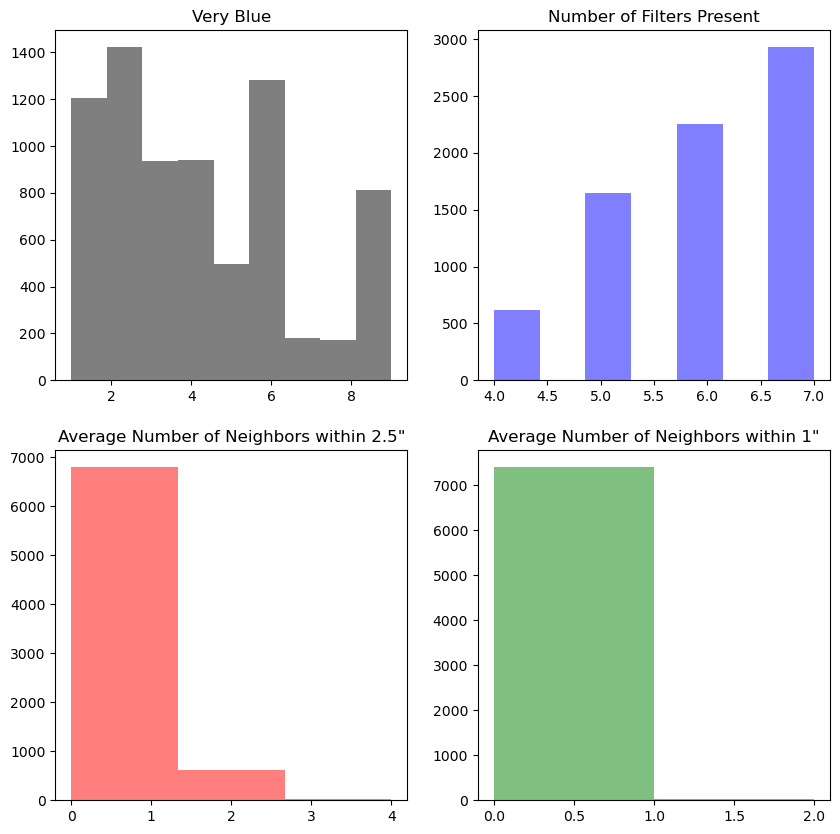

In [9]:
f,axes = plt.subplots(2,2, figsize=(10,10))
axes[0,0].hist(original_df["very_blue"].values, bins=9, color='k', alpha=0.5)
axes[0,0].set_title('Very Blue')
axes[0,1].hist(original_df["n_filters"].values, bins=7, color='b', alpha=0.5)
axes[0,1].set_title('Number of Filters Present')
axes[1,0].hist(original_df["avg_2p5"].values, bins=3, color='r', alpha=0.5)
axes[1,0].set_title('Average Number of Neighbors within 2.5"')
axes[1,1].hist(original_df["avg_1"].values, bins=2, color='g', alpha=0.5)
axes[1,1].set_title('Average Number of Neighbors within 1"')

In [14]:
# Get Star 15
s15 = pd.read_csv('../0_Data/GoldSampleCSVs/0_combined_colors.csv')
s15 = s15[s15['discovery_name'] == 'Star_15']

names = ['ra', 'dec', 'U', 'e_U', 'B', 'e_B', 'V', 'e_V', 'I', 'e_I',
       'uvw1_num_obs', 'uvw1_num_outliers', 'uvw1_mag', 'uvw1_mag_err',
       'uvw1_mag_std', 'uvw1_flux_frac', 'uvw1_flux_frac_std',
       'uvw1_resid_frac', 'uvw1_resid_frac_std', 'uvw1_std_unweighted',
       'uvw1_num5', 'uvw1_num2p5', 'uvw1_num1', 'uvw1_closest_mean',
       'uvw1_closest_min', 'uvw1_closest_std', 'uvw1_dist_moved',
       'uvw2_num_obs', 'uvw2_num_outliers', 'uvw2_mag', 'uvw2_mag_err',
       'uvw2_mag_std', 'uvw2_flux_frac', 'uvw2_flux_frac_std',
       'uvw2_resid_frac', 'uvw2_resid_frac_std', 'uvw2_std_unweighted',
       'uvw2_num5', 'uvw2_num2p5', 'uvw2_num1', 'uvw2_closest_mean',
       'uvw2_closest_min', 'uvw2_closest_std', 'uvw2_dist_moved',
       'uvm2_num_obs', 'uvm2_num_outliers', 'uvm2_mag', 'uvm2_mag_err',
       'uvm2_mag_std', 'uvm2_flux_frac', 'uvm2_flux_frac_std',
       'uvm2_resid_frac', 'uvm2_resid_frac_std', 'uvm2_std_unweighted',
       'uvm2_num5', 'uvm2_num2p5', 'uvm2_num1', 'uvm2_closest_mean',
       'uvm2_closest_min', 'uvm2_closest_std', 'uvm2_dist_moved',
       'uvw2_combined_err', 'uvw1_combined_err', 'uvm2_combined_err',
       'uvw2_mag_dered', 'uvm2_mag_dered', 'uvw1_mag_dered', 'U_dered',
       'B_dered', 'V_dered', 'I_dered', 'uvw2 - b', 'uvw2 - v', 'uvw2 - i',
       'uvw1 - b', 'uvw1 - v', 'uvw1 - i', 'uvm2 - b', 'uvm2 - v', 'uvm2 - i',
       'uvw2 - b overlap', 'uvw2 - v overlap', 'uvw2 - i overlap',
       'uvw1 - b overlap', 'uvw1 - v overlap', 'uvw1 - i overlap',
       'uvm2 - b overlap', 'uvm2 - v overlap', 'uvm2 - i overlap', 'galaxy',
       'discovery_name', 'n_blue', 'n_overlap', 'very_blue']

# Append S15
ndf = pd.concat([df[names],s15[names]])

# Only discovery sources 
ndf = ndf[ndf.discovery_name.notna()]


C:\Users\Betha\AppData\Local\Temp\ipykernel_34488\3613561450.py:2: DtypeWarning: Columns (78,79,80,97) have mixed types. Specify dtype option on import or set low_memory=False.
  s15 = pd.read_csv('../0_Data/GoldSampleCSVs/0_combined_colors.csv')


In [15]:
def Quad(X1,X2):
    return np.sqrt(X1**2+X2**2)
# Import photometry from discovery paper 
cols = ['Star', 'RA', 'DEC', 'n5', 'closest', 'UVW2', 'W2-FF','UVM2', 'M2-FF', 'UVW1', 'W1-FF', 'U', 'B', 'V', 'I']
disc = pd.read_csv('Discovery/discovery_photometry2.txt', delimiter='&',names=cols,header=0)
# Split into usable columns 
disc['uvw2'] = [float(row[1]) for row in disc['UVW2'].str.split('\t')]
disc['e_uvw2'] = [float(row[3]) for row in disc['UVW2'].str.split('\t')]
disc['uvm2'] = [float(row[1]) for row in disc['UVM2'].str.split('\t')]
disc['e_uvm2'] = [float(row[3]) for row in disc['UVM2'].str.split('\t')]
disc['uvw1'] = [float(row[1]) for row in disc['UVW1'].str.split('\t')]
disc['e_uvw1'] = [float(row[3]) for row in disc['UVW1'].str.split('\t')]
# Remove unnecessary columns
disc = disc[['Star', 'RA', 'DEC','uvw2','e_uvw2','uvm2','e_uvm2','uvw1','e_uvw1']]

for i in disc['Star']:
    disc.loc[disc['Star'] == i,'new_uvw2'] = ndf.loc[ndf.discovery_name == f'Star_{i}','uvw2_mag'].values[0]
    disc.loc[disc['Star'] == i,'new_uvm2'] = ndf.loc[ndf.discovery_name == f'Star_{i}','uvm2_mag'].values[0]
    disc.loc[disc['Star'] == i,'new_uvw1'] = ndf.loc[ndf.discovery_name == f'Star_{i}','uvw1_mag'].values[0]
    disc.loc[disc['Star'] == i,'new_uvw2_err'] = ndf.loc[ndf.discovery_name == f'Star_{i}','uvw2_mag_err'].values[0]
    disc.loc[disc['Star'] == i,'new_uvm2_err'] = ndf.loc[ndf.discovery_name == f'Star_{i}','uvm2_mag_err'].values[0]
    disc.loc[disc['Star'] == i,'new_uvw1_err'] = ndf.loc[ndf.discovery_name == f'Star_{i}','uvw1_mag_err'].values[0]
    disc.loc[disc['Star'] == i,'galaxy'] = ndf.loc[ndf.discovery_name == f'Star_{i}','galaxy'].values[0]
# Calculate the difference in magnitude
disc['del_uvw2'] = disc['new_uvw2'] - disc['uvw2']
disc['del_uvm2'] = disc['new_uvm2'] - disc['uvm2']
disc['del_uvw1'] = disc['new_uvw1'] - disc['uvw1']
# Calculate the error in the difference in magnitude
disc['del_uvw2_err'] = Quad(disc['new_uvw2_err'],disc['e_uvw2'])
disc['del_uvm2_err'] = Quad(disc['new_uvm2_err'],disc['e_uvm2'])
disc['del_uvw1_err'] = Quad(disc['new_uvw1_err'],disc['e_uvw1'])


colors_1 = ['#5f4b8b','#025043','#4be8f9'] 
colors_2 = ['#5f4b8b','#008080','#4be8f9'] 
colors_3 = ['#5f4b8b','#025043','#FFC6D9']  
colors_3 = ['#5f4b8b','#025043','#9A031E'] 
colors_4 = ['#5f4b8b','#025043','#0C120C'] 
colors_5 = ['#5f4b8b','#025043','#C4B7CB'] 
colors_6 = ['#5f4b8b','#008080','#931621'] 
colors = colors_2


plt.figure(figsize=(8,8))
ms = 12
plt.errorbar(disc['Star'], disc['del_uvw2'],yerr=disc['del_uvw2_err'],fmt='o',c=colors[0],ms=ms,zorder=10)
plt.errorbar(disc['Star'], disc['del_uvm2'],yerr=disc['del_uvm2_err'],fmt='o',c=colors[1],ms=ms)
plt.errorbar(disc['Star'], disc['del_uvw1'],yerr=disc['del_uvw1_err'],fmt='o',c=colors[2],ms=ms)

plt.scatter(0,-1,c=colors[0],label='UVW2',s=100)
plt.scatter(0,-1,c=colors[1],label='UVM2',s=100)
plt.scatter(0,-1,c=colors[2],label='UVW1',s=100)
plt.axhline(0,c='k',ls='--')
plt.xlabel(u'Star Number in Drout, Göetberg, Ludwig 2023',fontsize=20,color='black')
plt.ylabel('Difference in Magnitude',fontsize=20,color='black')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18,loc='upper left')
plt.xlim(0,26)
plt.ylim(-0.75,0.8)
plt.grid(True,alpha=0.3)
# make facecolor white
plt.gcf().patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(f'../../4_plots/DiscoveryComparison/ComparisonToDiscovery.png',bbox_inches='tight',dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: 'Discovery/discovery_photometry2.txt'

In [ ]:
def plot(cutname,directory):
    df = sample.copy()
    pdf = df[df.cut == cutname].copy().reset_index(drop=True)
    n_plots = np.ceil(pdf.shape[0] / 20)
    sed_columns = ['uvw2_mag_dered','uvm2_mag_dered','uvw1_mag_dered','U_dered','B_dered','V_dered','I_dered']
    err_columns = ['uvw2_mag_err','uvm2_mag_err','uvw1_mag_err','e_U','e_B','e_V','e_I']
    #Approximate central wavelengths in angstroms
    eff_wav = [1928,2246,2600,3639.3,4350.6,5369.6,7609.2] 

    start = 0
    stop = 20
    for i in np.arange(n_plots):
        f, axes = plt.subplots(5, 4, figsize=(20, 20))
        for ax, n in zip(axes.flatten(),np.arange(start,stop)):
            if n >= pdf.shape[0]:
                break
            row = pdf.iloc[n]
            sed = row[sed_columns].values
            err = row[err_columns].values
            ax.plot(eff_wav,sed,ls='--',color='black',alpha=0.5)
            ax.errorbar(eff_wav,sed,yerr=err,fmt='o',color='red')
            ax.set_xticks(eff_wav)
            ax.set_xticklabels(['W2','M2','W1','U','B','V','I'])
            ax.set_ylim(20,14)
            ax.grid(alpha=0.4)
            ax.set_title(f'{row.SUMS_ID} - {row.cut}')

        plt.savefig(f'{directory}{row.SUMS_ID}.png',bbox_inches='tight')
        plt.close()
        start += 20
        stop += 20

cuts = ['platinum', 'silver', 'gold', 'diamond']
for cut in cuts:
    print(cut)
    plot(cut,f'Plots/Candidates/{cut.capitalize()}/')

platinum
silver
gold
diamond


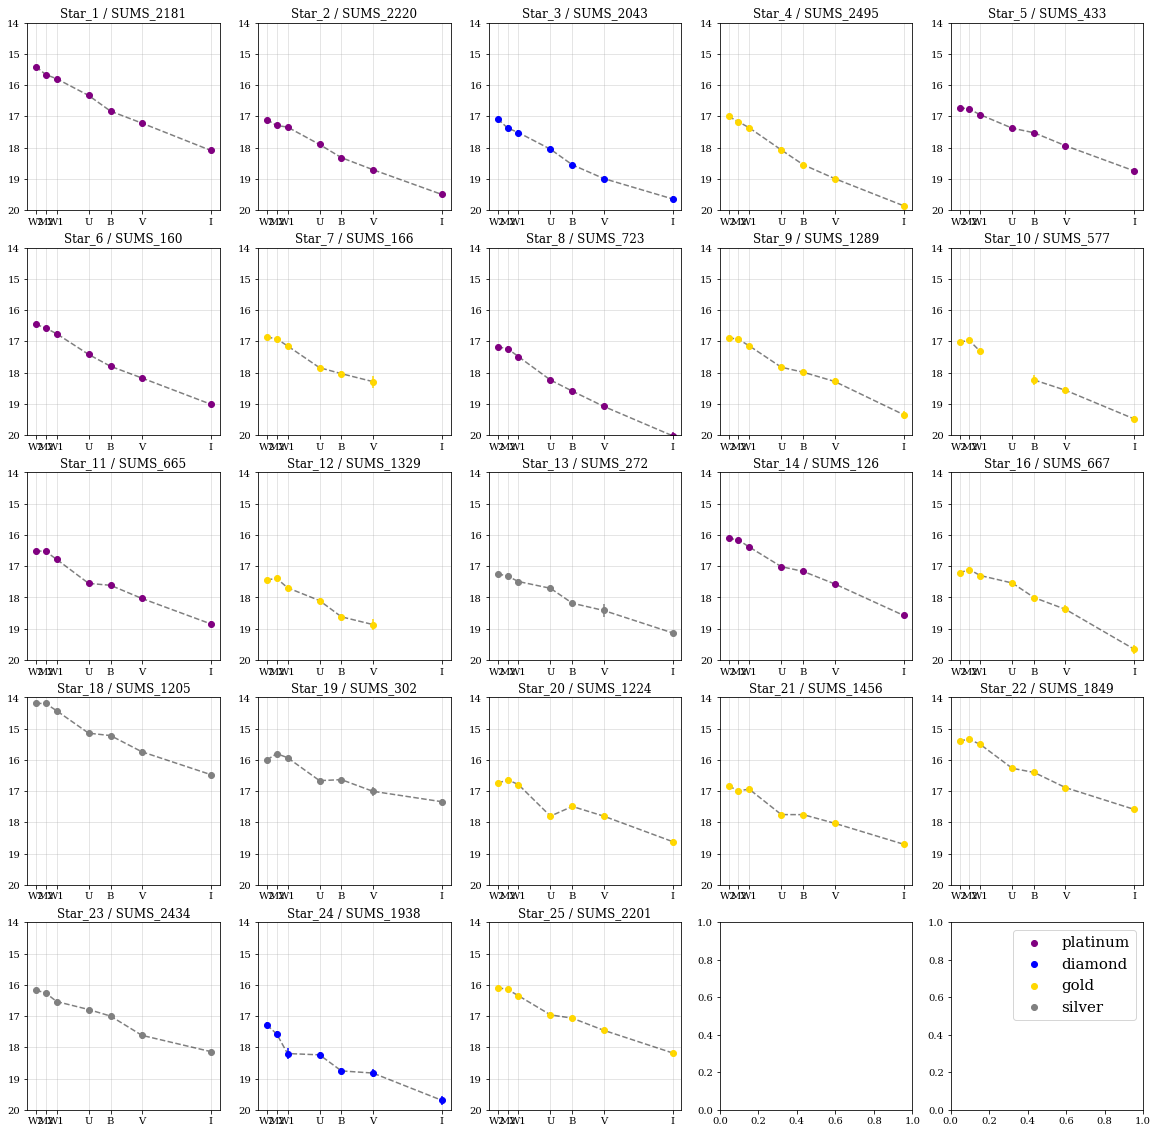

In [ ]:
discovery = sample[~sample['discovery_name'].isna()].reset_index(drop=True)
# Resort so discovery names are in order
discovery['ind'] = discovery.discovery_name.str.split('_').str[1].astype(int)
discovery = discovery.sort_values(by='ind').reset_index(drop=True)
# Set the sed columns and error columns
sed_columns = ['uvw2_mag_dered','uvm2_mag_dered','uvw1_mag_dered','U_dered','B_dered','V_dered','I_dered']
err_columns = ['uvw2_mag_err','uvm2_mag_err','uvw1_mag_err','e_U','e_B','e_V','e_I']
#Approximate central wavelengths in angstroms
eff_wav = [1928,2246,2600,3639.3,4350.6,5369.6,7609.2] 
discovery.shape[0]
colors = {'platinum':'purple','diamond':'blue','gold':'gold','silver':'grey'}
f, axes = plt.subplots(5, 5, figsize=(20, 20))
for ind,row in discovery.iterrows():
    ax = axes.flatten()[ind]
    sed = row[sed_columns].values
    err = row[err_columns].values
    ax.plot(eff_wav,sed,ls='--',color='black',alpha=0.5)
    ax.errorbar(eff_wav,sed,yerr=err,fmt='o',color=colors[row.cut])
    ax.set_xticks(eff_wav)
    ax.set_xticklabels(['W2','M2','W1','U','B','V','I'])
    ax.set_ylim(20,14)
    ax.grid(alpha=0.4)
    ax.set_title(f'{row.discovery_name} / {row.SUMS_ID}')
lax = axes.flatten()[-1]
lax.set_ylim(0,1)
lax.set_xlim(0,1)
for key in colors.keys():
    lax.scatter([],[],label=key,color=colors[key])
lax.legend(loc='upper right',fontsize=15)
f.patch.set_facecolor('white')
plt.savefig(f'Plots/Candidates/Discovery_SED/discoverysed.png',bbox_inches='tight')
    


In [ ]:

colors.keys()

dict_keys(['platinum', 'diamond', 'gold', 'silver'])

In [ ]:
row = sample.iloc[0]
row.SUMS_ID

'SUMS_0'